# Setup

In [1]:
!pip install scikit-learn
!pip install numpy
!pip install scipy
!pip install sysidentpy
!pip install matplotlib==3.1.3
!pip install catboost

  Using cached matplotlib-3.1.3.tar.gz (40.9 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for matplotlib
Failed to build matplotlib
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.6.2
    Uninstalling matplotlib-3.6.2:
      Successfully uninstalled matplotlib-3.6.2
  Running setup.py install for matplotlib: started
  Running setup.py install for matplotlib: finished with status 'error'
  Rolling back uninstall of matplotlib
  Moving to c:\users\walte\.conda\envs\ml\lib\site-packages\__pycache__\pylab.cpython-39.pyc
   from C:\Users\walte\AppData\Local\Temp\pip-uninstall-e5ovglma\pylab.cpython-39.pyc
  Moving to c:\users\walte\.conda\envs\ml\lib\site-packages\matplotlib-3.6.2-py3.9-nspkg.pth
   from C:\Users\walte\AppData\Local\Temp\pip-uninstall-owmuaach\matplotlib-3.6.2-py3.9-nspkg.pth
  Moving to c:\users\walte\.conda\envs\ml\lib\site-packages\matplotlib-3.6.2.dist-

  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [528 lines of output]
      Edit setup.cfg to change the build options
      
      BUILDING MATPLOTLIB
        matplotlib: yes [3.1.3]
            python: yes [3.9.15 | packaged by conda-forge | (main, Nov 22 2022,
                        08:41:22) [MSC v.1929 64 bit (AMD64)]]
          platform: yes [win32]
      
      OPTIONAL SUBPACKAGES
       sample_data: yes [installing]
             tests: no  [skipping due to configuration]
      
      OPTIONAL BACKEND EXTENSIONS
               agg: yes [installing]
             tkagg: yes [installing; run-time loading from Python Tcl/Tk]
            macosx: no  [Mac OS-X only]
      
      OPTIONAL PACKAGE DATA
              dlls: no  [skipping due to configuration]
      
      C:\Users\walte\.conda\envs\ml\lib\site-packages\setuptools\dist.py:286: SetuptoolsDeprecationWarning: The namespace_packages parameter is deprec

https://sysidentpy.org/

# NARX with exogenous inputs

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function import Polynomial, Fourier
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.generate_data import get_siso_data,get_miso_data
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation

from sklearn.model_selection import TimeSeriesSplit
import scipy.io

In [10]:
d34 = scipy.io.loadmat('../toy_island/Data_34.mat',simplify_cells=True)

Set up the training and testing data

In [11]:
xl = []
yl = []
for i in range(len(d34["u2"])):
  xl.append([d34["u2"][i],d34["v2"][i]])#,d34["w2"][i]])
  yl.append(d34["v2"][i])

x = np.array(xl)
y = np.array([yl])
y=y.transpose()

# Add in a 2 period gap
tscv = TimeSeriesSplit(n_splits=2, test_size=50, gap=10)
for train_index, test_index in tscv.split(x):
  # print("TRAIN:", train_index, "TEST:", test_index)
  x_train, x_valid = x[train_index], x[test_index]
  y_train, y_valid = y[train_index], y[test_index]


print(x_train.shape); print(x_valid.shape);print(y_train.shape); print(y_valid.shape)

(5367, 2)
(50, 2)
(5367, 1)
(50, 1)


In [12]:
basis_function = Polynomial(degree=2)

model = FROLS(
    order_selection=True,
    n_terms=4,
    extended_least_squares=False,
    ylag=2, xlag=[[1,2],[1,2]],
    info_criteria='aic',
    estimator='least_squares',
    basis_function=basis_function
)

In [13]:
model.fit(X=x_train, y=y_train)

0.9465133106629052
  Regressors   Parameters             ERR
0     y(k-1)   1.3314E+00  9.43587621E-01
1   y(k-2)^2  -3.5902E-02  1.03038148E-02
2     y(k-2)  -3.8027E-01  2.64020724E-03
3    x1(k-2)   9.7328E-02  1.48775507E-03


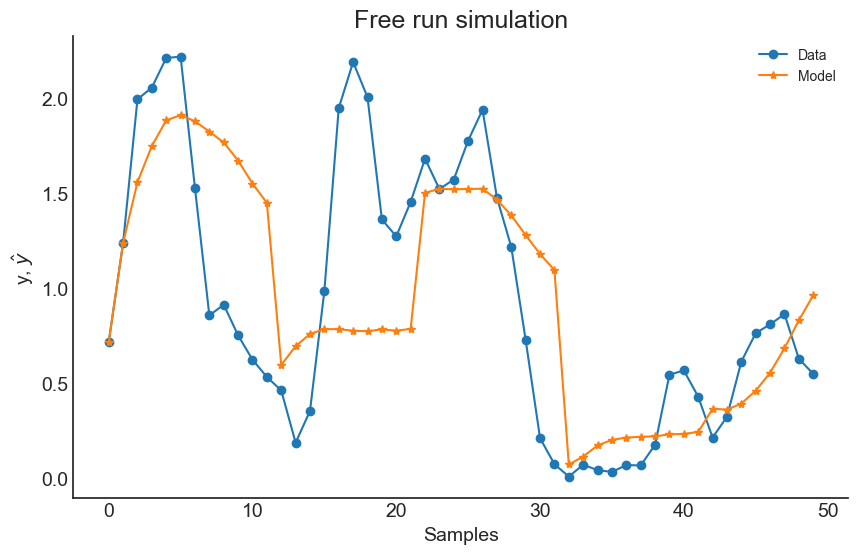

In [14]:
#predicting 10 time steps ahead
yhat = model.predict(X=x_valid, y=y_valid,steps_ahead=10)
rrse = root_relative_squared_error(y_valid, yhat)
print(rrse)

r = pd.DataFrame(
    results(
        model.final_model, model.theta, model.err,
        model.n_terms, err_precision=8, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
print(r)
plot_results(y=y_valid, yhat = yhat, n=1000)
ee = compute_residues_autocorrelation(y_valid, yhat)
# plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
# x1e = compute_cross_correlation(y_valid, yhat, x_valid[:, 0])
# plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")

0.36149510690078773
  Regressors   Parameters             ERR
0     y(k-1)   1.3314E+00  9.43587621E-01
1   y(k-2)^2  -3.5902E-02  1.03038148E-02
2     y(k-2)  -3.8027E-01  2.64020724E-03
3    x1(k-2)   9.7328E-02  1.48775507E-03


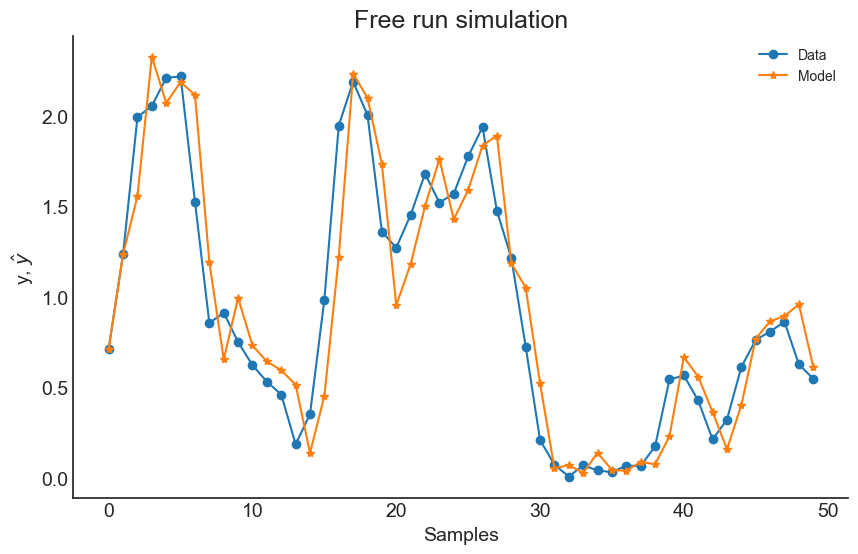

In [15]:
#predicting 1 timestep ahead (much easier for network)
yhat = model.predict(X=x_valid, y=y_valid,steps_ahead=1)
rrse = root_relative_squared_error(y_valid, yhat)
print(rrse)

r = pd.DataFrame(
    results(
        model.final_model, model.theta, model.err,
        model.n_terms, err_precision=8, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
print(r)
plot_results(y=y_valid, yhat = yhat, n=1000)
ee = compute_residues_autocorrelation(y_valid, yhat)
# plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
# x1e = compute_cross_correlation(y_valid, yhat, x_valid[:, 0])
# plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")